## Anomaly Detection

In [1]:
from __future__ import division
# from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import numpy as np
import pandas as pd
import collections
from random import randint
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
%matplotlib inline

In [2]:
sns.set(color_codes=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Content
Each row consists of four columns:

 - `date`: `yyyy-mm-dd` (from 2006-07-01 through 2006-09-30)
 - `l_ipn`: local IP (coded as an integer from 0-9)
 - `r_asn`: remote ASN (an integer which identifies the remote ISP)
 - `f`: flows (count of connnections for that day)

Reports of "odd" activity or suspicions about a machine's behavior triggered investigations on the following days (although the machine might have been compromised earlier)


Acknowledgements
This public dataset was found on http://statweb.stanford.edu/~sabatti/data.html

In [4]:
df = pd.read_csv("../dataset/cs448b_ipasn.csv")

# 2. View the data as a table
df.head(10)

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
7,2006-07-01,0,4134,3
8,2006-07-01,0,5617,2
9,2006-07-01,0,6478,1


In [5]:
df['date'].value_counts().shape

(92,)

In [6]:
def reduceData(df):
    cols = df.columns
    m = {}
    d = []
    for row in df.values:
        key = "%s-%s" % (row[0], row[1])
        if key not in m:
            m[key] = [row[0], row[1], "", 0]
            
        m[key][2] += " " +str(row[2])
        m[key][3] += row[3]
        
    for k, v in m.items():
        d.append(v)
        
    return pd.DataFrame(d, columns=cols)

In [7]:
df2 = reduceData(df)

In [8]:
df2.head(10)

,date,l_ipn,r_asn,f
0,2006-08-25,8,49 109 174 271 378 1239 1668 1742 2152 3464 3...,470
1,2006-08-22,6,2914 3269 3356 4134 4538 4750 6478 7545 8560 ...,120
2,2006-07-25,5,1955 2152 3462 3561 3595 3786 4134 4713 5713 ...,88
3,2006-07-24,5,8 2152 3257 3269 3340 3491 3561 4134 4230 476...,69
4,2006-07-02,0,209 701 766 2514 2711 2819 2856 3269 3320 356...,920
5,2006-09-30,7,2152 4766 8070 8075 14425 18924,106
6,2006-08-24,7,109 714 2152 3701 6057 7859 8070 9156 12182 1...,129
7,2006-08-19,4,137 3292 3462 4134 7018 8972 9318 13749 14778...,516
8,2006-08-18,4,3561 6428 6802 7018 7132 9583 13767 14743 147...,456
9,2006-09-17,7,109 1239 2152 4766 7015 8070 18924,76


In [9]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

In [10]:
df2.index = df2['date']

In [11]:
df2 = df2.drop(['date'], axis=1)

## Analysis of IP 6

Let's look at the no of connections per day

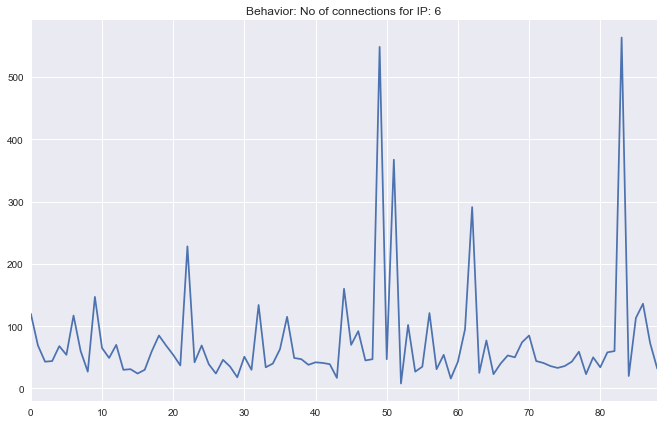

In [12]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]
df3['f_mean'] = df3['f'].mean()

plt.figure(figsize=(10,7))
sns.tsplot(data=df3['f'], ci="sd")
# sns.tsplot(df3['f_mean'], color='red')

plt.title("Behavior: No of connections for IP: %s" % ip)
plt.show()

In [13]:
mvsum = 0
mvcount = 0
mvavg = []

for f in df3['f'].values:
    mvsum += f
    mvcount += 1
    mvavg.append(mvsum / mvcount)
    
df3['mvavg'] = mvavg

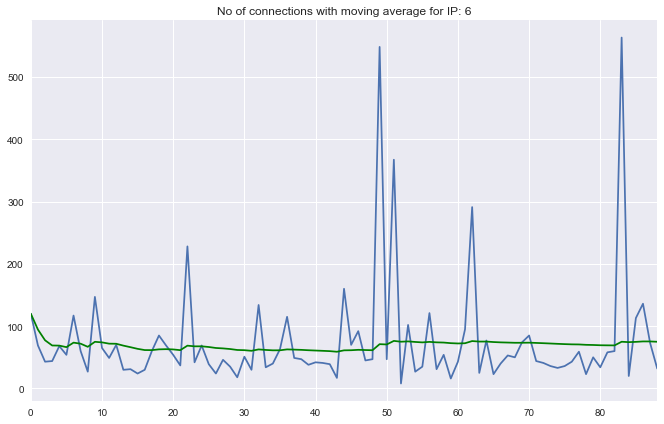

In [14]:
plt.figure(figsize=(10,7))
sns.tsplot(df3['f'])
sns.tsplot(df3['mvavg'], color='green')

plt.title("No of connections with moving average for IP: %s" % ip)
plt.show()

In [15]:
mvavg = []
mvstd = []
mvpost = []
mvnegt = []
W = 2

for i in range(df3.shape[0]):
    _a = df3['f'].values[:i + 1].mean()
    _s = df3['f'].values[:i + 1].std()
    mvavg.append(_a)
    mvstd.append(_s)
    
    mvpost.append(_a + (_s * W))
    mvnegt.append(_a - (_s * W))


df3['mvavg'] = mvavg
df3['mvstd'] = mvstd
df3['mvpost'] = mvpost
df3['mvnegt'] = mvnegt

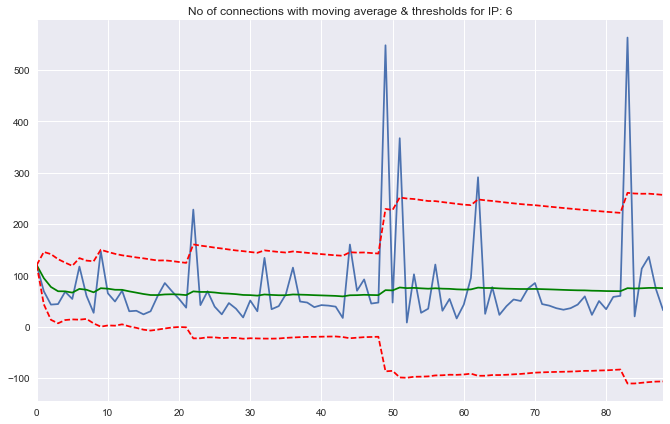

In [16]:
plt.figure(figsize=(10,7))
sns.tsplot(df3['f'])
sns.tsplot(df3['mvavg'], color='green')

sns.tsplot(df3['mvpost'], color='red', linestyle='--')
sns.tsplot(df3['mvnegt'], color='red', linestyle='--')


plt.title("No of connections with moving average & thresholds for IP: %s" % ip)
plt.show()

In [17]:
mvavg = []
mvstd = []
mvpost = []
mvnegt = []
W = 3
S = 10

anomalies = []

points = np.array([0])
for i, f in enumerate(df3['f'].values):
    _a = points.mean()
    _s = points.std()
    _pt = _a + (_s * W)
    _nt = _a - (_s * W)
    
    if i > S and (f > _pt or f < _nt):
        mvavg.append(mvavg[i-1])
        mvstd.append(mvstd[i-1])
        mvpost.append(mvpost[i-1])
        mvnegt.append(mvnegt[i-1])
        
        points = np.append(points, [_a])
        anomalies.append(f)
        continue

    mvavg.append(_a)
    mvstd.append(_s)  
    mvpost.append(_pt)
    mvnegt.append(_nt)
    points = np.append(points, [f])
    anomalies.append(np.float('nan'))


df3['mvavg'] = mvavg
df3['mvstd'] = mvstd
df3['mvpost'] = mvpost
df3['mvnegt'] = mvnegt
df3['anomalies'] = anomalies

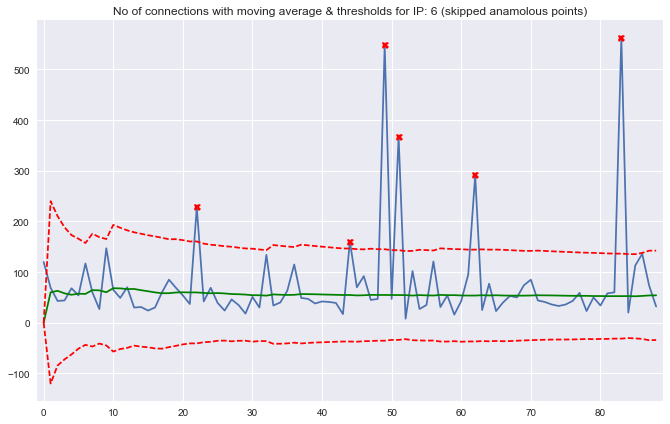

In [18]:
plt.figure(figsize=(10,7))
sns.tsplot(df3['f'])
ax = sns.tsplot(df3['mvavg'], color='green')
# ax.errorbar(df3.index, df3['mvavg'], yerr=df3['mvstd'])#, fmt='-o') #fmt=None to plot bars only

sns.tsplot(df3['mvpost'], color='red', linestyle='--')
sns.tsplot(df3['mvnegt'], color='red', linestyle='--')

ax = sns.tsplot(df3['anomalies'], color='red', marker="x", interpolate=False)
ax.lines[-1].set_marker("X")

plt.title("No of connections with moving average & thresholds for IP: %s (skipped anamolous points)" % ip)
plt.show()

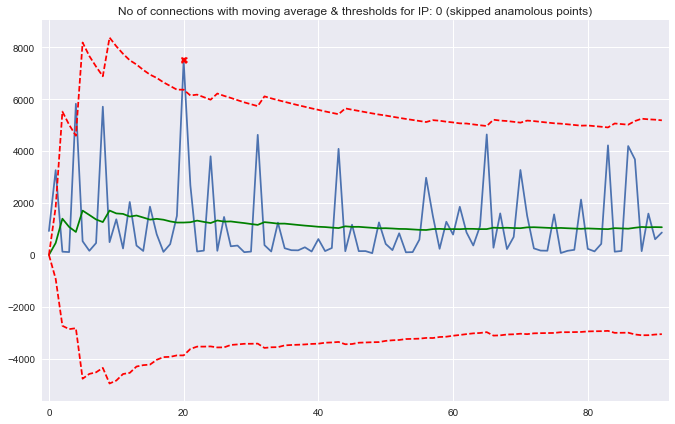

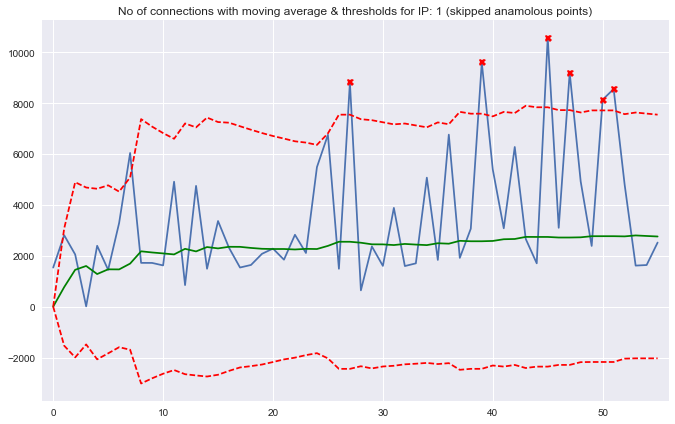

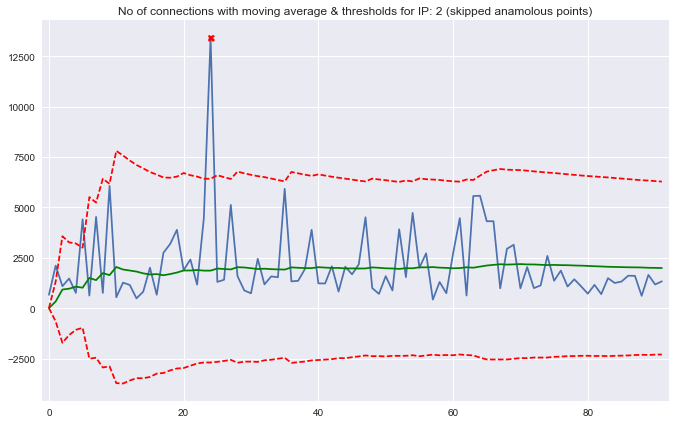

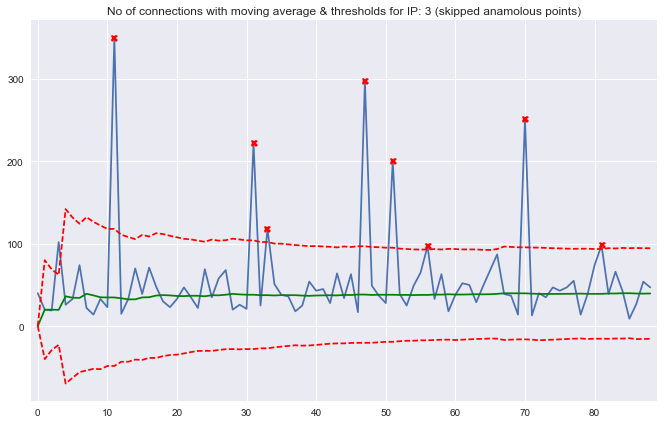

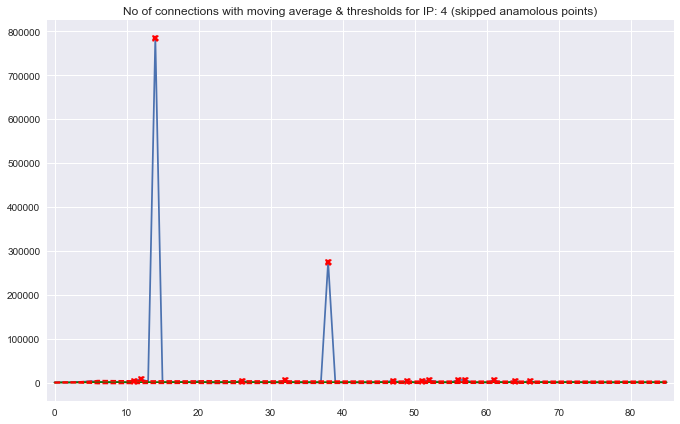

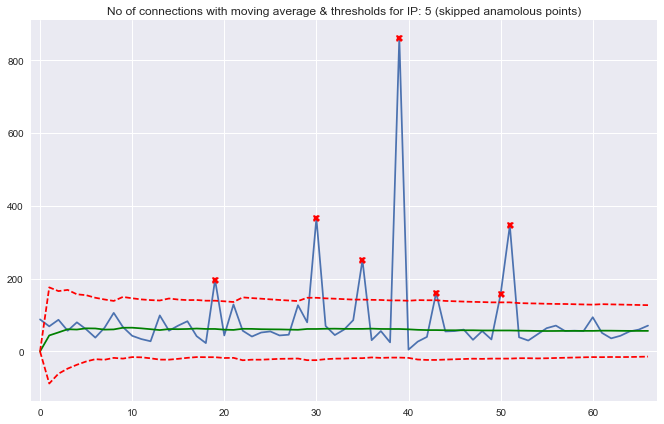

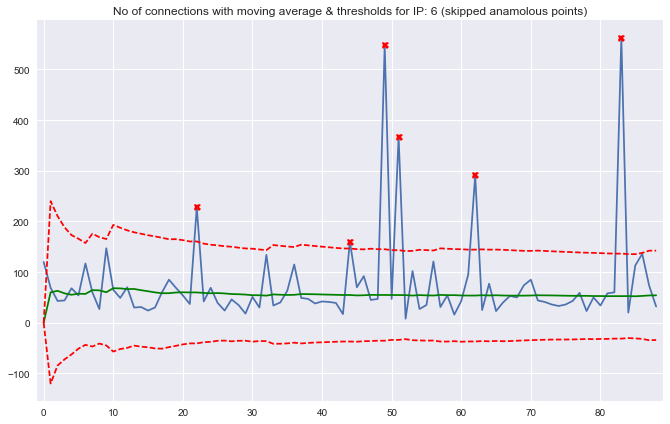

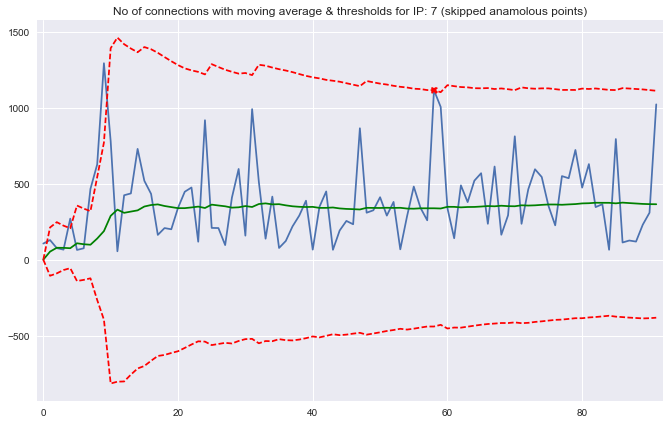

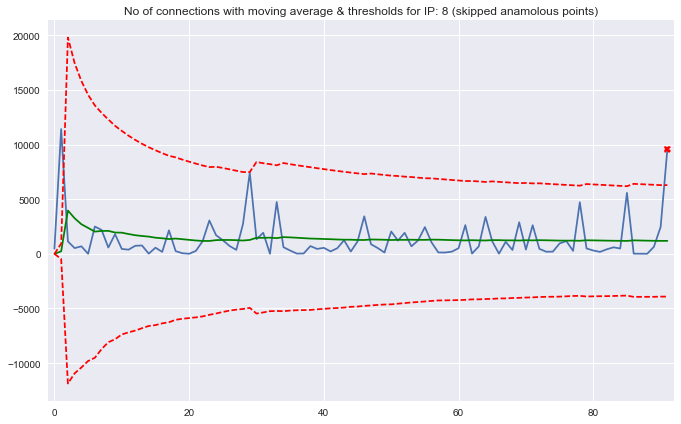

In [19]:
W = 3
S = 10

for ip in range(0, 9):
    df3 = df2[df2['l_ipn'] == ip]
    mvavg = []
    mvstd = []
    mvpost = []
    mvnegt = []


    anomalies = []

    points = np.array([0])
    for i, f in enumerate(df3['f'].values):
        _a = points.mean()
        _s = points.std()
        _pt = _a + (_s * W)
        _nt = _a - (_s * W)

        if i > S and (f > _pt or f < _nt):
            mvavg.append(mvavg[i-1])
            mvstd.append(mvstd[i-1])
            mvpost.append(mvpost[i-1])
            mvnegt.append(mvnegt[i-1])

            points = np.append(points, [_a])
            anomalies.append(f)
            continue

        mvavg.append(_a)
        mvstd.append(_s)  
        mvpost.append(_pt)
        mvnegt.append(_nt)
        points = np.append(points, [f])
        anomalies.append(np.float('nan'))


    df3['mvavg'] = mvavg
    df3['mvstd'] = mvstd
    df3['mvpost'] = mvpost
    df3['mvnegt'] = mvnegt
    df3['anomalies'] = anomalies
    
    plt.figure(figsize=(10,7))
    sns.tsplot(df3['f'])
    sns.tsplot(df3['mvavg'], color='green')

    sns.tsplot(df3['mvpost'], color='red', linestyle='--')
    sns.tsplot(df3['mvnegt'], color='red', linestyle='--')

    ax = sns.tsplot(df3['anomalies'], color='red', marker="x", interpolate=False)
    ax.lines[-1].set_marker("X")

    plt.title("No of connections with moving average & thresholds for IP: %s (skipped anamolous points)" % ip)
    plt.show()

## Bag of word + PCA approach on remote ISP contacted

In [20]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]

df4 = df3[['r_asn', 'f']]
df4.head(10)

,r_asn,f
date,,
2006-08-22,2914 3269 3356 4134 4538 4750 6478 7545 8560 ...,120
2006-09-22,4134 4230 9812 17447 17557 18566 24139 24400 ...,69
2006-09-14,701 1668 1916 4134 4618 4732 4812 4837 8820 9...,43
2006-09-23,73 225 1659 2500 3561 4134 4323 4812 6746 685...,44
2006-09-20,3269 3462 4134 4230 4812 4837 6517 8560 9318 ...,68
2006-07-13,4134 4230 4766 4812 4814 7015 8151 8972 9394 ...,54
2006-07-21,81 4134 4812 4837 6221 6724 7132 8151 8321 93...,117
2006-08-05,3561 3591 4134 4323 4515 4665 4732 4812 5413 ...,60
2006-07-02,766 3269 3354 4134 4808 4812 4837 13749 17184,27


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df4['f_white'] = scaler.fit_transform(df4['f'].values)

c:\users\minhazv\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\users\minhazv\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(df4['r_asn'].values)

In [23]:
print ("Shape of the vectors: %d X %d" % (X.shape[0], X.shape[1]))

Shape of the vectors: 89 X 493


In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X.toarray())
X_transformed = pca.transform(X.toarray())

In [25]:
df4['pca_0'] = X_transformed[:,0]
df4['pca_1'] = X_transformed[:,1]

In [26]:
df4.head(10)

,r_asn,f,f_white,pca_0,pca_1
date,,,,,
2006-08-22,2914 3269 3356 4134 4538 4750 6478 7545 8560 ...,120,0.495653,0.469770,0.314236
2006-09-22,4134 4230 9812 17447 17557 18566 24139 24400 ...,69,-0.065947,0.759644,-0.219081
2006-09-14,701 1668 1916 4134 4618 4732 4812 4837 8820 9...,43,-0.352253,-0.850368,0.574632
2006-09-23,73 225 1659 2500 3561 4134 4323 4812 6746 685...,44,-0.341241,0.004765,0.139363
2006-09-20,3269 3462 4134 4230 4812 4837 6517 8560 9318 ...,68,-0.076959,-0.813979,0.827168
2006-07-13,4134 4230 4766 4812 4814 7015 8151 8972 9394 ...,54,-0.231123,-0.090032,-0.510881
2006-07-21,81 4134 4812 4837 6221 6724 7132 8151 8321 93...,117,0.462618,-0.235323,0.018651
2006-08-05,3561 3591 4134 4323 4515 4665 4732 4812 5413 ...,60,-0.165053,0.269038,-0.780077
2006-07-02,766 3269 3354 4134 4808 4812 4837 13749 17184,27,-0.528441,-0.546965,0.103675


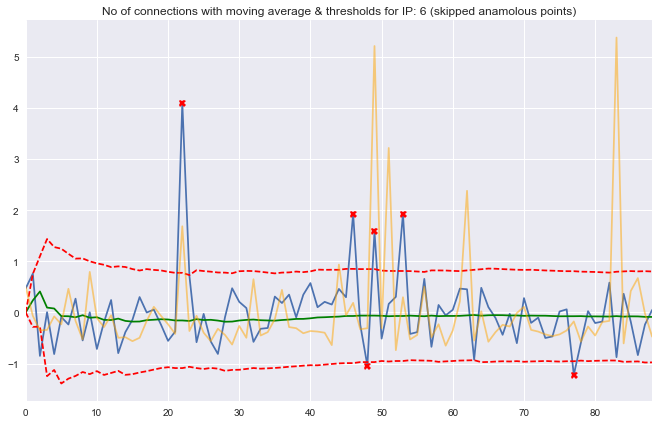

In [27]:
W = 2.2
mvavg = []
mvstd = []
mvpost = []
mvnegt = []
anomalies = []

pca_col = 'pca_0'

points = np.array([0])
for i, f in enumerate(df4[pca_col].values):
    _a = points.mean()
    _s = points.std()
    _pt = _a + (_s * W)
    _nt = _a - (_s * W)

    if i > S and (f > _pt or f < _nt):
        mvavg.append(mvavg[i-1])
        mvstd.append(mvstd[i-1])
        mvpost.append(mvpost[i-1])
        mvnegt.append(mvnegt[i-1])

        points = np.append(points, [_a])
        anomalies.append(f)
        continue

    mvavg.append(_a)
    mvstd.append(_s)  
    mvpost.append(_pt)
    mvnegt.append(_nt)
    points = np.append(points, [f])
    anomalies.append(np.float('nan'))


df4['mvavg'] = mvavg
df4['mvstd'] = mvstd
df4['mvpost'] = mvpost
df4['mvnegt'] = mvnegt
df4['anomalies'] = anomalies

plt.figure(figsize=(10,7))
sns.tsplot(df4[pca_col])
sns.tsplot(df4['mvavg'], color='green')

sns.tsplot(df4['mvpost'], color='red', linestyle='--')
sns.tsplot(df4['mvnegt'], color='red', linestyle='--')

ax = sns.tsplot(df4['anomalies'], color='red', marker="x", interpolate=False)
ax.lines[-1].set_marker("X")

plt.title("No of connections with moving average & thresholds for IP: %s (skipped anamolous points)" % ip)

sns.tsplot(df4['f_white'], color='orange', alpha=0.5)
plt.show()

## Using linkedIn opensource Luminol package

Luminol is a light weight python library for time series data analysis. The two major functionalities it supports are anomaly detection and correlation. It can be used to investigate possible causes of anomaly. You collect time series data and Luminol can:

Given a time series, detect if the data contains any anomaly and gives you back a time window where the anomaly happened in, a time stamp where the anomaly reaches its severity, and a score indicating how severe is the anomaly compare to others in the time series.
Given two time series, help find their correlation coefficient. Since the correlation mechanism allows a shift room, you are able to correlate two peaks that are slightly apart in time.

In [28]:
from luminol.anomaly_detector import AnomalyDetector

In [33]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]
df3['date'] = df3.index
df3.head(10)
ts = df3['f'].values

In [47]:
ts = {}
for i, f in enumerate(df3['f'].values):
    ts[i] = f

my_detector = AnomalyDetector(ts)
score = my_detector.get_all_scores()
anomalies = my_detector.get_anomalies()

In [49]:
df3['anomalies'] = np.float('nan')
anom = df3['anomalies'].values
for a in anomalies:
    tp = a.get_time_window()
    anom[tp[0]] = df3['f'].values[tp[0]]
    
df3['anomalies'] = anom

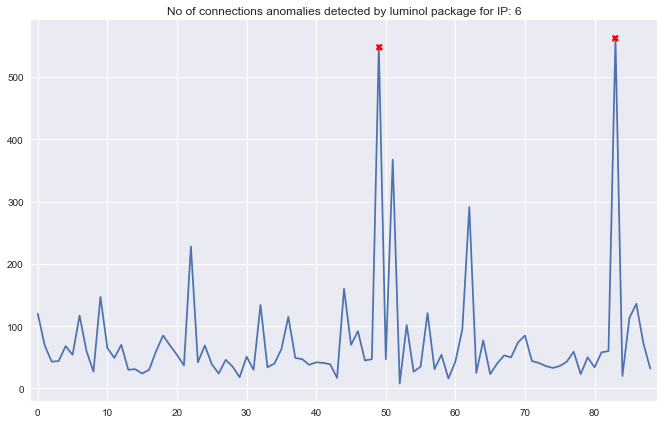

In [50]:
plt.figure(figsize=(10,7))
sns.tsplot(df3['f'])
ax = sns.tsplot(df3['anomalies'], color='red', marker="x", interpolate=False)
ax.lines[-1].set_marker("X")

plt.title("No of connections anomalies detected by luminol package for IP: %s" % ip)
plt.show()

## Using prediction models with error threshold

In [ ]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
ip = 6
df3 = df2[df2['l_ipn'] == ip]
df3.head(10)

## Using auto encoders with reconstruction errors